# Datawhale 气象海洋预测-Task4 模型建立之 TCNN+RNN
本次任务我们将学习来自TOP选手“swg-lhl”的冠军建模方案，该方案中采用的模型是TCNN+RNN

在Task3中我们学习了CNN+LSTM模型，但是LSTM有四个门，构建一个LSTM层的参数量非常大，这就带来以下问题：一是参数量大在数据量小的情况下模型容易过拟合；二是为了尽量避免过拟合，在有限的数据集下我们无法构建更深层的模型，难以挖掘到更复杂的信息，这一点在可用的特征数非常少的情况下是很不利的。相较于LSTM，CNN的参数量只与过滤器的大小有关，在各类任务中往往都有不错的表现，因此我们可以考虑同样用卷积操作来挖掘时间信息。但是如果用三维卷积来同时挖掘时间和空间信息，假设使用的过滤器大小为(T_f, H_f, W_f)，那么一层的参数量就是T_f×H_f×W_f，这样的参数量仍然是比较大的。为了进一步降低每一层的参数，增加模型深度，我们本次学习的这个TOP方案对时间和空间分别进行卷积操作，即采用TCN单元挖掘时间信息，然后输入CNN单元中挖掘空间信息，将TCN单元+CNN单元的串行结构称为TCNN层，通过堆叠多层的TCNN层就可以很好地挖掘到复杂的时空信息。同时，考虑到不同时间尺度下的时空信息对预测结果的影响可能是不同的，该方案采用了三个RNN层来抽取三种时间尺度下的特征，将三者拼接起来得到最终的预测结果。

可以看出，该方案是基于给定的数据集情况、基于问题背景深刻理解后得出来的，希望同学们在学习的过程中能够深入思考，将这种建模方法灵活迁移到其他任务中。

## 学习目标
1. 学习TOP方案的模型构建方法

## 内容介绍
1. 数据处理
    - 数据扁平化
    - 空值填充
    - 构造数据集
2. 模型构建
    - 构造评估函数
    - 模型构造
    - 模型训练
    - 模型评估
3. 总结

## 代码示例

### 数据处理
该TOP方案的数据处理主要包括三部分：
1. 数据扁平化。
2. 空值填充。
3. 构造数据集
在该方案中除了没有构造新的特征外，其他数据处理方法都与Task3基本相同，因此不多做赘述。

In [1]:
import netCDF4 as nc
import random
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error

In [2]:
# 固定随机种子
SEED = 22

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(SEED)

In [3]:
# 查看GPU是否可用
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# 读取数据

# 存放数据的路径
path = '/kaggle/input/ninoprediction/'
soda_train = nc.Dataset(path + 'SODA_train.nc')
soda_label = nc.Dataset(path + 'SODA_label.nc')
cmip_train = nc.Dataset(path + 'CMIP_train.nc')
cmip_label = nc.Dataset(path + 'CMIP_label.nc')

#### 数据扁平化
采用滑窗构造数据集。

In [5]:
def make_flatted(train_ds, label_ds, info, start_idx=0):
    keys = ['sst', 't300', 'ua', 'va']
    label_key = 'nino'
    # 年数
    years = info[1]
    # 模式数
    models = info[2]
    
    train_list = []
    label_list = []
    
    # 将同种模式下的数据拼接起来
    for model_i in range(models):
        blocks = []
        
        # 对每个特征，取每条数据的前12个月进行拼接
        for key in keys:
            block = train_ds[key][start_idx + model_i * years: start_idx + (model_i + 1) * years, :12].reshape(-1, 24, 72, 1).data
            blocks.append(block)
        
        # 将所有特征在最后一个维度上拼接起来
        train_flatted = np.concatenate(blocks, axis=-1)
        
        # 取12-23月的标签进行拼接，注意加上最后一年的最后12个月的标签（与最后一年12-23月的标签共同构成最后一年前12个月的预测目标）
        label_flatted = np.concatenate([
            label_ds[label_key][start_idx + model_i * years: start_idx + (model_i + 1) * years, 12: 24].reshape(-1).data,
            label_ds[label_key][start_idx + (model_i + 1) * years - 1, 24: 36].reshape(-1).data
        ], axis=0)
        
        train_list.append(train_flatted)
        label_list.append(label_flatted)
        
    return train_list, label_list

In [6]:
soda_info = ('soda', 100, 1)
cmip6_info = ('cmip6', 151, 15)
cmip5_info = ('cmip5', 140, 17)

soda_trains, soda_labels = make_flatted(soda_train, soda_label, soda_info)
cmip6_trains, cmip6_labels = make_flatted(cmip_train, cmip_label, cmip6_info)
cmip5_trains, cmip5_labels = make_flatted(cmip_train, cmip_label, cmip5_info, cmip6_info[1]*cmip6_info[2])

# 得到扁平化后的数据维度为（模式数×序列长度×纬度×经度×特征数），其中序列长度=年数×12
np.shape(soda_trains), np.shape(cmip6_trains), np.shape(cmip5_trains)

((1, 1200, 24, 72, 4), (15, 1812, 24, 72, 4), (17, 1680, 24, 72, 4))

#### 空值填充
将空值填充为0。

In [8]:
# 填充SODA数据中的空值
soda_trains = np.array(soda_trains)
soda_trains_nan = np.isnan(soda_trains)
soda_trains[soda_trains_nan] = 0
print('Number of null in soda_trains after fillna:', np.sum(np.isnan(soda_trains)))

Number of null in soda_trains after fillna: 0


In [9]:
# 填充CMIP6数据中的空值
cmip6_trains = np.array(cmip6_trains)
cmip6_trains_nan = np.isnan(cmip6_trains)
cmip6_trains[cmip6_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip6_trains)))

Number of null in cmip6_trains after fillna: 0


In [10]:
# 填充CMIP5数据中的空值
cmip5_trains = np.array(cmip5_trains)
cmip5_trains_nan = np.isnan(cmip5_trains)
cmip5_trains[cmip5_trains_nan] = 0
print('Number of null in cmip6_trains after fillna:', np.sum(np.isnan(cmip5_trains)))

Number of null in cmip6_trains after fillna: 0


#### 构造数据集
构造训练和验证集。

In [11]:
# 构造训练集

X_train = []
y_train = []
# 从CMIP5的17种模式中各抽取100条数据
for model_i in range(17):
    samples = np.random.choice(cmip5_trains.shape[1]-12, size=100)
    for ind in samples:
        X_train.append(cmip5_trains[model_i, ind: ind+12])
        y_train.append(cmip5_labels[model_i][ind: ind+24])
# 从CMIP6的15种模式种各抽取100条数据
for model_i in range(15):
    samples = np.random.choice(cmip6_trains.shape[1]-12, size=100)
    for ind in samples:
        X_train.append(cmip6_trains[model_i, ind: ind+12])
        y_train.append(cmip6_labels[model_i][ind: ind+24])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [12]:
# 构造验证集

X_valid = []
y_valid = []
samples = np.random.choice(soda_trains.shape[1]-12, size=100)
for ind in samples:
    X_valid.append(soda_trains[0, ind: ind+12])
    y_valid.append(soda_labels[0][ind: ind+24])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [13]:
# 查看数据集维度
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3200, 12, 24, 72, 4), (3200, 24), (100, 12, 24, 72, 4), (100, 24))

In [15]:
# 保存数据集
np.save('X_train_sample.npy', X_train)
np.save('y_train_sample.npy', y_train)
np.save('X_valid_sample.npy', X_valid)
np.save('y_valid_sample.npy', y_valid)

### 模型构建

这一部分我们来重点学习一下该方案的模型结构。

In [16]:
# 读取数据集
X_train = np.load('../input/ai-earth-task04-samples/X_train_sample.npy')
y_train = np.load('../input/ai-earth-task04-samples/y_train_sample.npy')
X_valid = np.load('../input/ai-earth-task04-samples/X_valid_sample.npy')
y_valid = np.load('../input/ai-earth-task04-samples/y_valid_sample.npy')

In [17]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3200, 12, 24, 72, 4), (3200, 24), (100, 12, 24, 72, 4), (100, 24))

In [18]:
# 构造数据管道
class AIEarthDataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [19]:
batch_size = 32

trainset = AIEarthDataset(X_train, y_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validset = AIEarthDataset(X_valid, y_valid)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)

#### 构造评估函数

In [24]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_pred = y_preds, y_true = y_true))

# 评估函数
def score(y_true, y_preds):
    # 相关性技巧评分
    accskill_score = 0
    # RMSE
    rmse_scores = 0
    a = [1.5] * 4 + [2] * 7 + [3] * 7 + [4] * 6
    y_true_mean = np.mean(y_true, axis=0)
    y_pred_mean = np.mean(y_preds, axis=0)
    for i in range(24):
        fenzi = np.sum((y_true[:, i] - y_true_mean[i]) * (y_preds[:, i] - y_pred_mean[i]))
        fenmu = np.sqrt(np.sum((y_true[:, i] - y_true_mean[i])**2) * np.sum((y_preds[:, i] - y_pred_mean[i])**2))
        cor_i = fenzi / fenmu
        accskill_score += a[i] * np.log(i+1) * cor_i
        rmse_score = rmse(y_true[:, i], y_preds[:, i])
        rmse_scores += rmse_score
    return 2/3.0 * accskill_score - rmse_scores

#### 模型构造

该TOP方案采用TCN单元+CNN单元串行组成TCNN层，通过堆叠多层的TCNN层来交替地提取时间和空间信息，并将提取到的时空信息用RNN来抽取出三种不同时间尺度的特征表达。

- **TCN单元**

TCN模型全称时间卷积网络（Temporal Convolutional Network），与RNN一样是时序模型。TCN以CNN为基础，为了适应序列问题，它从以下三方面做出了改进：

1. 因果卷积

TCN处理输入与输出等长的序列问题，它的每一个隐藏层节点数与输入步长是相同的，并且隐藏层t时刻节点的值只依赖于前一层t时刻及之前节点的值。也就是说TCN通过追溯前因（t时刻及之前的值）来获得当前结果，称为因果卷积。

2. 扩张卷积

传统CNN的感受野受限于卷积核的大小，需要通过增加池化层来获得更大的感受野，但是池化的操作会带来信息的损失。为了解决这个问题，TCN采用扩张卷积来增大感受野，获取更长时间的信息。扩张卷积对输入进行间隔采样，采样间隔由扩张因子d控制，公式定义如下：
$$
F(s) = (X * df)(s) = \sum_{i=0}^{k-1} f(i) \times X_{s-di}
$$
其中X为当前层的输入，k为当前层的卷积核大小，s为当前节点的时刻。也就是说，对于扩张因子为d、卷积核为k的隐藏层，对前一层的输入每d个点采样一次，共采样k个点作为当前时刻s的输入。这样TCN的感受野就由卷积核的大小k和扩张因子d共同决定，可以获取更长时间的依赖信息。

<img src="./fig/Task4-扩张卷积.png" width="45%">

3. 残差连接

网络的层数越多，所能提取到的特征就越丰富，但这也会带来梯度消失或爆炸的问题，目前解决这个问题的一个有效方法就是残差连接。TCN的残差模块包含两层卷积操作，并且采用了WeightNorm和Dropout进行正则化，如下图所示。

<img src="./fig/Task4-残差连接.png" width="60%">

总的来说，TCN是卷积操作在序列问题上的改进，具有CNN参数量少的优点，可以搭建更深层的网络，相比于RNN不容易存在梯度消失和爆炸的问题，同时TCN具有灵活的感受野，能够适应不同的任务，在许多数据集上的比较表明TCN比RNN、LSTM、GRU等序列模型有更好的表现。

想要更深入地了解TCN可以参考以下链接：
    
   - 论文原文：https://arxiv.org/pdf/1803.01271.pdf
   - GitHub：https://github.com/locuslab/tcn
   
该方案中所构建的TCN单元并不是标准的TCN层，它的结构如下图所示，可以看到，这里的TCN单元只是用了一个卷积层，并且在卷积层前后都采用了BatchNormalization来提高模型的泛化能力。需要注意的是，这里的卷积操作是对时间维度进行操作，因此需要对输入的形状进行转换，并且为了便于匹配之后的网络层，需要将输出的形状转换回输入时的（N,T,C,H,W）的形式。

<img src="./fig/Task4-TCN单元.png" width="26%">

In [20]:
# 构建TCN单元
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        if in_channels == out_channels and stride == 1:
            self.res = lambda x: x
        else:
            self.res = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride)
        
    def forward(self, x):
        # 转换输入形状
        N, T, C, H, W = x.shape
        x = x.permute(0, 3, 4, 2, 1).contiguous()
        x = x.view(N*H*W, C, T)
        
        # 残差
        res = self.res(x) 
        res = self.bn2(res)

        x = F.relu(self.bn1(x))
        x = self.conv(x)
        x = self.bn2(x)
        
        x = x + res
        
        # 将输出转换回(N,T,C,H,W)的形式
        _, C_new, T_new = x.shape
        x = x.view(N, H, W, C_new, T_new)
        x = x.permute(0, 4, 3, 1, 2).contiguous()
        
        return x

- **CNN单元**

CNN单元结构与TCN单元相似，都只有一个卷积层，并且使用BatchNormalization来提高模型泛化能力。同时，类似TCN单元，CNN单元中也加入了残差连接。结构如下图所示：

<img src="./fig/Task4-CNN单元.png" width="26%">

In [21]:
# 构建CNN单元
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if (in_channels == out_channels) and (stride == 1):
            self.res = lambda x: x
        else:
            self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        
    def forward(self, x):
        # 转换输入形状
        N, T, C, H, W = x.shape
        x = x.view(N*T, C, H, W)
        
        # 残差
        res = self.res(x)
        res = self.bn2(res)

        x = F.relu(self.bn1(x))
        x = self.conv(x)
        x = self.bn2(x)
        
        x = x + res
        
        # 将输出转换回(N,T,C,H,W)的形式
        _, C_new, H_new, W_new = x.shape
        x = x.view(N, T, C_new, H_new, W_new)
        
        return x

- **TCNN层**

将TCN单元和CNN单元串行连接，就构成了一个TCNN层。

<img src="./fig/Task4-TCNN层.png" width="15%">

In [22]:
class TCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride_tcn, stride_cnn, padding):
        super().__init__()
        self.tcn = TCNBlock(in_channels, out_channels, kernel_size, stride_tcn, padding)
        self.cnn = CNNBlock(out_channels, out_channels, kernel_size, stride_cnn, padding)
        
    def forward(self, x):
        x = self.tcn(x)
        x = self.cnn(x)
        return x

- **TCNN+RNN模型**

整体的模型结构如下图所示：

<img src="./fig/Task4-TCNN+RNN模型.png" width="40%">

1. TCNN部分

TCNN部分的模型结构类似传统CNN的结构，非常规整，通过逐渐增加通道数来提取更丰富的特征表达。需要注意的是输入数据的格式是(N,T,H,W,C)，为了匹配卷积层的输入格式，需要将数据格式转换为(N,T,C,H,W)。

2. GAP层

GAP全称为全局平均池化（Global Average Pooling）层，它的作用是把每个通道上的特征图取全局平均，假设经过TCNN部分得到的输出格式为(N,T,C,H,W)，那么GAP层就会把每个通道上形状为H×W的特征图上的所有值求平均，最终得到的输出格式就变成(N,T,C)。GAP层最早出现在论文《Network in Network》（论文原文：https://arxiv.org/pdf/1312.4400.pdf ）中用于代替传统CNN中的全连接层，之后的许多实验证明GAP层确实可以提高CNN的效果。

那么GAP层为什么可以代替全连接层呢？在传统CNN中，经过多层卷积和池化的操作后，会由Flatten层将特征图拉伸成一列，然后经过全连接层，那么对于形状为(C,H,W)的一条数据，经Flatten层拉伸后的长度为C×H×W，此时假设全连接层节点数为U，全连接层的参数量就是C×H×W×U，这么大的参数量很容易使得模型过拟合。相比之下，GAP层不引入新的参数，因此可以有效减少过拟合问题，并且模型参数少也能加快训练速度。另一方面，全连接层是一个黑箱子，我们很难解释多分类的信息是怎样传回卷积层的，而GAP层就很容易理解，每个通道的值就代表了经过多层卷积操作后所提取出来的特征。更详细的理解可以参考https://www.zhihu.com/question/373188099

在Pytorch中没有内置的GAP层，因此可以用adaptive_avg_pool2d来替代，这个函数可以将特征图压缩成给定的输出形状，将output_size参数设置为(1,1)，就等同于GAP操作，函数的详细使用方法可以参考https://pytorch.org/docs/stable/generated/torch.nn.functional.adaptive_avg_pool2d.html?highlight=adaptive_avg_pool2d#torch.nn.functional.adaptive_avg_pool2d

3. RNN部分

至此为止我们所使用的都是长度为12的时间序列，每个时间步代表一个月的信息。不同尺度的时间序列所携带的信息是不尽相同的，比如用长度为6的时间序列来表达一年的SST值，那么每个时间步所代表的就是两个月的SST信息，这种时间尺度下的SST序列与长度为12的SST序列所反映的一年中SST变化趋势等信息就不完全相同。所以，为了尽可能全面地挖掘更多信息，该TOP方案中用MaxPool层来获得三种不同时间尺度的序列，同时，用RNN层来抽取序列的特征表达。RNN非常适合用于线性序列的自动特征提取，例如对于形状为(T,C1)的一条输入数据，R经过节点数为C2的RNN层就能抽取出长度为C2的向量，由于RNN由前往后进行信息线性传递的网络结构，抽取出的向量能够很好地表达序列中的依赖关系。

此时三种不同时间尺度的序列都抽取出了一个向量来表示，将向量拼接起来再经过一个全连接层就得到了24个月的预测序列。

In [23]:
# 构造模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3)
        self.tcnn1 = TCNNBlock(64, 64, 3, 1, 1, 1)
        self.tcnn2 = TCNNBlock(64, 128, 3, 1, 2, 1)
        self.tcnn3 = TCNNBlock(128, 128, 3, 1, 1, 1)
        self.tcnn4 = TCNNBlock(128, 256, 3, 1, 2, 1)
        self.tcnn5 = TCNNBlock(256, 256, 3, 1, 1, 1)
        self.rnn = nn.RNN(256, 256, batch_first=True)
        self.maxpool = nn.MaxPool1d(2)
        self.fc = nn.Linear(256*3, 24)
        
    def forward(self, x):
        # 转换输入形状
        N, T, H, W, C = x.shape
        x = x.permute(0, 1, 4, 2, 3).contiguous()
        x = x.view(N*T, C, H, W)
        
        # 经过一个卷积层
        x = self.conv(x)
        _, C_new, H_new, W_new = x.shape
        x = x.view(N, T, C_new, H_new, W_new)
        
        # TCNN部分
        for i in range(3):
            x = self.tcnn1(x)
        x = self.tcnn2(x)
        for i in range(2):
            x = self.tcnn3(x)
        x = self.tcnn4(x)
        for i in range(2):
            x = self.tcnn5(x)
            
        # 全局平均池化
        x = F.adaptive_avg_pool2d(x, (1, 1)).squeeze()
        
        # RNN部分，分别得到长度为T、T/2、T/4三种时间尺度的特征表达，注意转换RNN层输出的格式
        hidden_state = []
        for i in range(3):
            x, h = self.rnn(x)
            h = h.squeeze()
            hidden_state.append(h)
            x = self.maxpool(x.transpose(1, 2)).transpose(1, 2)
        
        x = torch.cat(hidden_state, dim=1)
        x = self.fc(x)
        
        return x

In [25]:
model = Model()
print(model)

Model(
  (conv): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (tcnn1): TCNNBlock(
    (tcn): TCNBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (cnn): CNNBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (tcnn2): TCNNBlock(
    (tcn): TCNBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

#### 模型训练

In [26]:
# 采用RMSE作为损失函数
def RMSELoss(y_pred,y_true):
    loss = torch.sqrt(torch.mean((y_pred-y_true)**2, dim=0)).sum()
    return loss

In [27]:
model_weights = './task04_model_weights.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Model().to(device)
criterion = RMSELoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
train_losses, valid_losses = [], []
scores = []
best_score = float('-inf')
preds = np.zeros((len(y_valid),24))

for epoch in range(epochs):
    print('Epoch: {}/{}'.format(epoch+1, epochs))
    
    # 模型训练
    model.train()
    losses = 0
    for data, labels in tqdm(trainloader):
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, labels)
        losses += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()
    train_loss = losses / len(trainloader)
    train_losses.append(train_loss)
    print('Training Loss: {:.3f}'.format(train_loss))
    
    # 模型验证
    model.eval()
    losses = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(validloader)):
            data, labels = data
            data = data.to(device)
            labels = labels.to(device)
            pred = model(data)
            loss = criterion(pred, labels)
            losses += loss.cpu().detach().numpy()
            preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu().numpy()
    valid_loss = losses / len(validloader)
    valid_losses.append(valid_loss)
    print('Validation Loss: {:.3f}'.format(valid_loss))
    s = score(y_valid, preds)
    scores.append(s)
    print('Score: {:.3f}'.format(s))
    
    # 保存最佳模型权重
    if s > best_score:
        best_score = s
        checkpoint = {'best_score': s,
                      'state_dict': model.state_dict()}
        torch.save(checkpoint, model_weights)

Epoch: 1/10


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Training Loss: 18.099


4it [00:00,  6.19it/s]


Validation Loss: 16.756
Score: -4.320
Epoch: 2/10


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]


Training Loss: 16.955


4it [00:00,  6.41it/s]


Validation Loss: 17.657
Score: -32.332
Epoch: 3/10


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Training Loss: 16.639


4it [00:00,  6.29it/s]


Validation Loss: 19.156
Score: -25.483
Epoch: 4/10


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]


Training Loss: 16.173


4it [00:00,  6.29it/s]


Validation Loss: 18.130
Score: -15.470
Epoch: 5/10


100%|██████████| 100/100 [00:45<00:00,  2.17it/s]


Training Loss: 15.818


4it [00:00,  6.28it/s]


Validation Loss: 17.367
Score: -14.745
Epoch: 6/10


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Training Loss: 15.464


4it [00:00,  6.28it/s]


Validation Loss: 18.289
Score: -4.441
Epoch: 7/10


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Training Loss: 15.175


4it [00:00,  6.26it/s]


Validation Loss: 18.604
Score: -21.144
Epoch: 8/10


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Training Loss: 15.004


4it [00:00,  6.27it/s]


Validation Loss: 18.593
Score: -27.508
Epoch: 9/10


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Training Loss: 14.578


4it [00:00,  6.28it/s]


Validation Loss: 18.264
Score: -19.113
Epoch: 10/10


100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


Training Loss: 14.330


4it [00:00,  6.27it/s]


Validation Loss: 17.739
Score: -18.628


In [28]:
# 绘制训练/验证曲线
def training_vis(train_losses, valid_losses):
    # 绘制损失函数曲线
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(train_losses, label='train_loss')
    ax1.plot(valid_losses,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    plt.tight_layout()

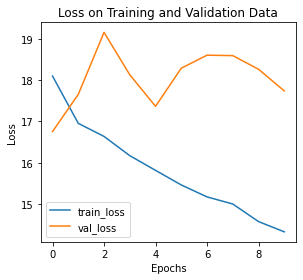

In [29]:
training_vis(train_losses, valid_losses)

#### 模型评估

在测试集上评估模型效果。

In [30]:
# 加载最佳模型权重
checkpoint = torch.load('../input/ai-earth-model-weights/task04_model_weights.pth')
model = Model()
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [31]:
# 测试集路径
test_path = '../input/ai-earth-tests/'
# 测试集标签路径
test_label_path = '../input/ai-earth-tests-labels/'

In [32]:
import os

# 读取测试数据和测试数据的标签
files = os.listdir(test_path)
X_test = []
y_test = []
for file in files:
    X_test.append(np.load(test_path + file))
    y_test.append(np.load(test_label_path + file))

In [33]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape, y_test.shape

((103, 12, 24, 72, 4), (103, 24))

In [34]:
testset = AIEarthDataset(X_test, y_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [35]:
# 在测试集上评估模型效果
model.eval()
model.to(device)
preds = np.zeros((len(y_test),24))
for i, data in tqdm(enumerate(testloader)):
    data, labels = data
    data = data.to(device)
    labels = labels.to(device)
    pred = model(data)
    preds[i*batch_size:(i+1)*batch_size] = pred.detach().cpu().numpy()
s = score(y_test, preds)
print('Score: {:.3f}'.format(s))

4it [00:00, 12.75it/s]

Score: 20.274


## 总结

总结起来，该方案主要有以下两方面值得我们学习：

- 充分考虑到数据量小、特征少的数据情况，对时间和空间分别进行卷积操作，用GAP层对提取的信息进行降维，尽可能减少每一层的参数量、增加模型层数以提取更丰富的特征。
- 对问题背景有深刻地理解，考虑到不同时间尺度序列所携带的信息不同，用池化层变换时间尺度，并用RNN进行信息提取，综合三种不同时间尺度的序列信息得到最终的预测序列。

该方案在构造模型时充分考虑了数据集情况和问题背景，并能灵活运用各种网络层来处理特定问题，这种模型构造思路要求对各种网络层的作用有较为深刻地理解。希望大家在学习该方案的时候不仅能够学习模型的构造方法，同时也能够在今后的其他任务中逐渐体会和掌握这种模型的构造思路。

## 参考文献

1. Top1思路分享：https://tianchi.aliyun.com/forum/postDetail?spm=5176.12586969.1002.6.561d482cp7CFlx&postId=210391